Based on the tutorial
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import numpy as np
import pickle as pkl
import music21 as m21
from IPython.display import Image
from tqdm import tqdm_notebook
import time
from pythonosc import udp_client, dispatcher, osc_server

In [2]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Dense, Activation, Embedding, Flatten, Dropout, Input, Reshape, Lambda
from keras.layers import LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import to_categorical, Sequence

Using TensorFlow backend.


In [3]:
allBach = m21.corpus.search('bach')
s1 = allBach[1].parse()

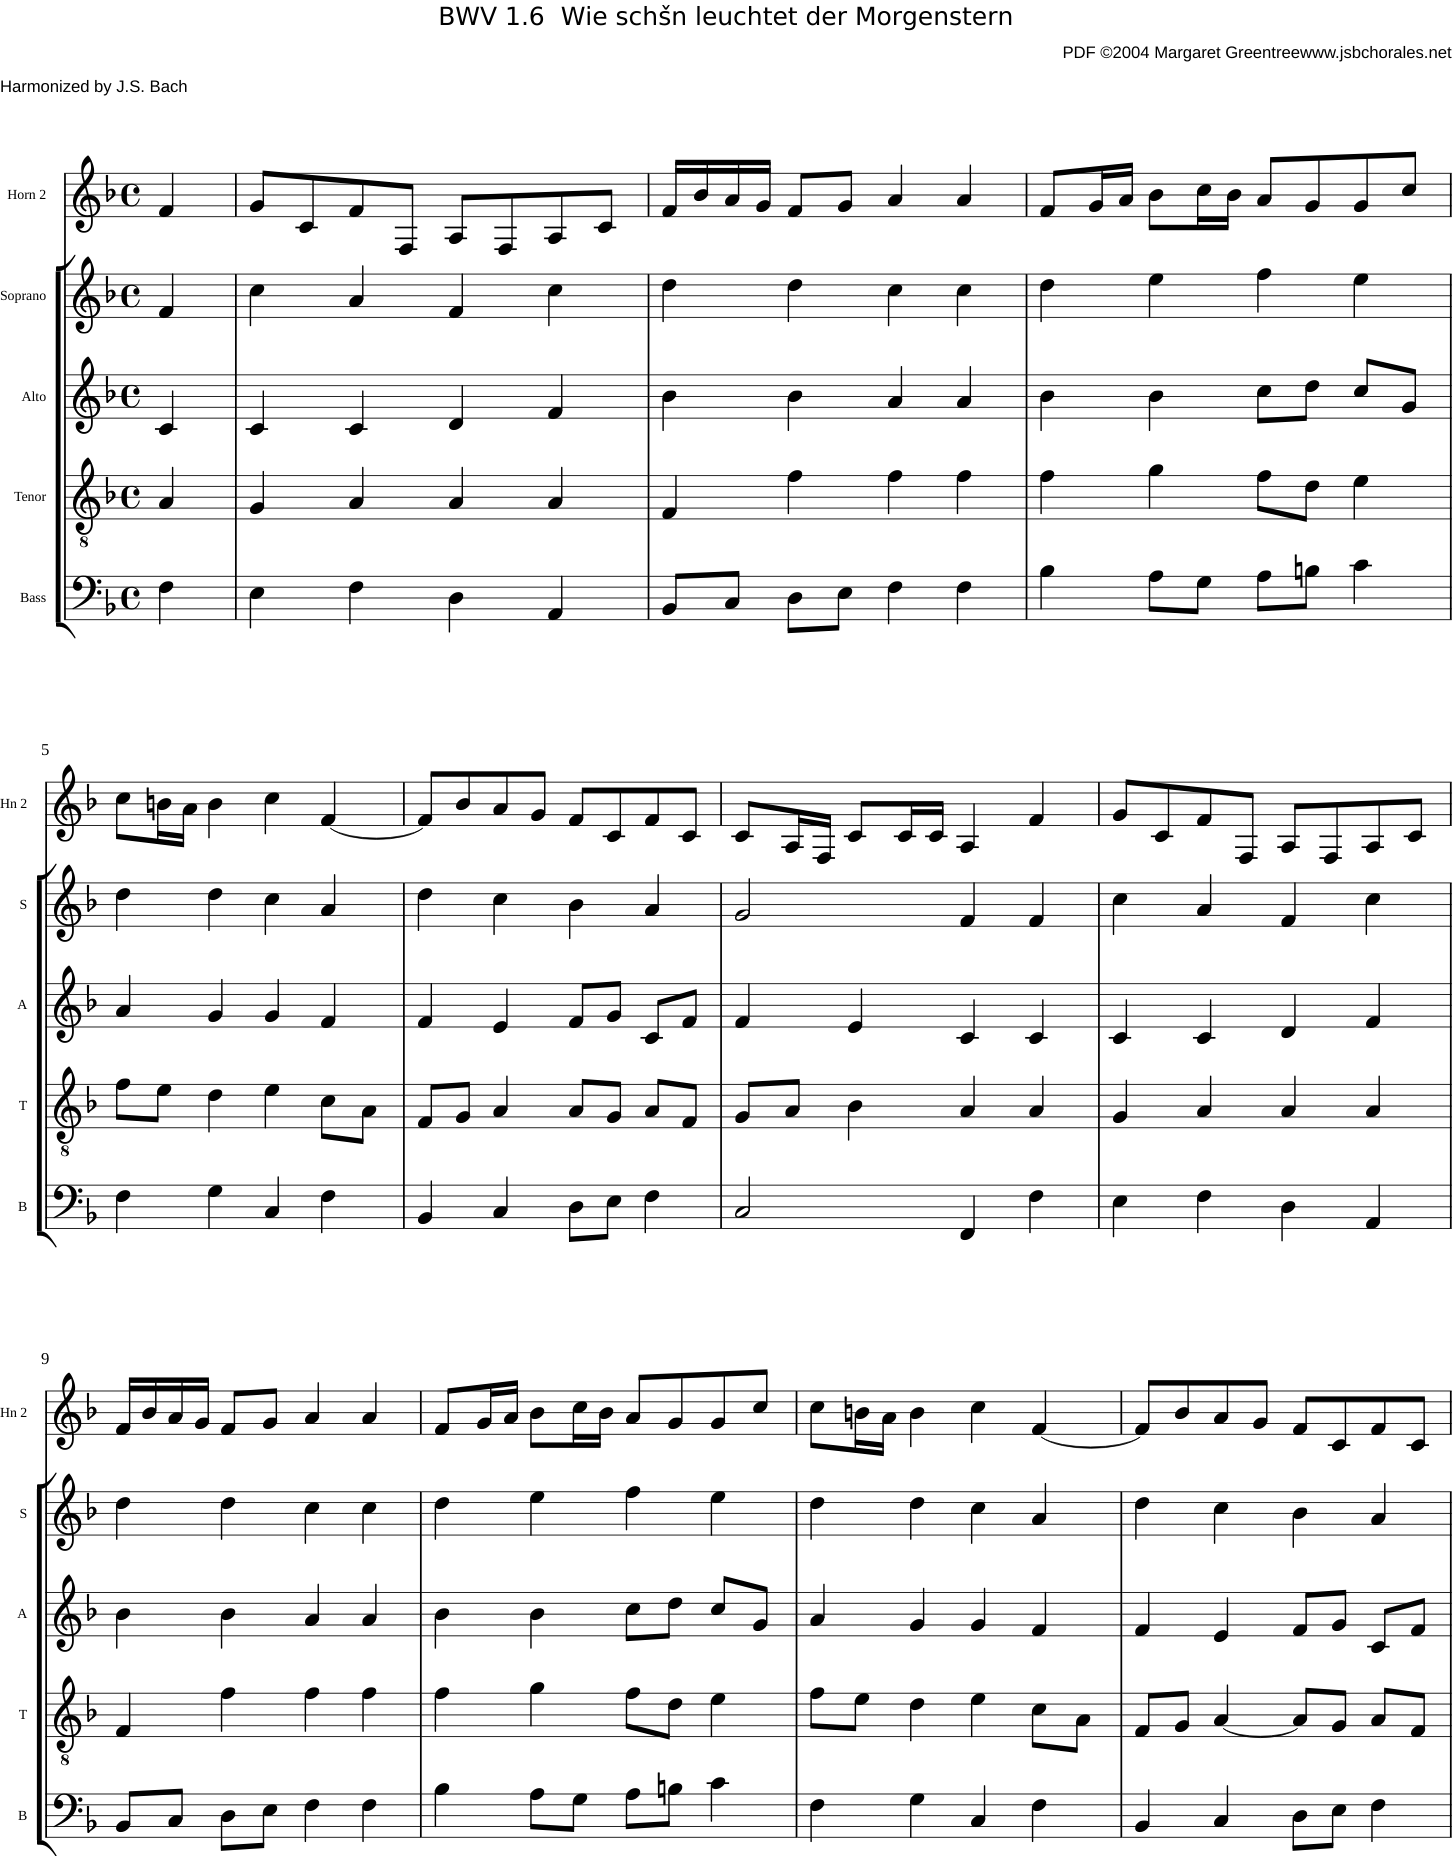

In [4]:
s1.show()

In [91]:
# test show()
stream2 = m21.stream.Stream()
n3 = m21.note.Note('D#5') # octave values can be included in creation arguments
stream2.repeatAppend(n3, 4)
stream2.show()

SubConverterFileIOException: png file of xml not found. Or file >999 pages?

In [108]:
def seqToOneHot(seq, vocabulary, length=None):
    '''
    converts an integer sequence to a one-hot encoding for parsing data
    '''
    if not length:
        length = len(seq)
    
    one_hot = np.zeros((length, vocabulary))
    for i, x in enumerate(seq):
        one_hot[i, x] = 1
    return one_hot

In [109]:
seqToOneHot([1, 2, 1], 5, length=10)

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [8]:
''' Load and parse data '''

allBach = m21.corpus.search('bach')
print('Loaded corpus...')
input_data = []   # will also be the target data for the autoencoder

word_to_id = {'SOM': 0, 'EOM': 1}   # dictionary of tokens
counter = 2

# iterate over all pieces:
for piece in tqdm_notebook(allBach):
    score = piece.parse()
    
    # transcribe to middle C
    dt = 60 - score.analyze('key').tonic.midi
    
    # iterate over all parts:
    for part in score.transpose(dt).parts:
        # iterate over all measures:
        for m in part.getElementsByClass('Measure'):
            bar = [word_to_id['SOM']]
            
            for x in m.flat.notes:
                if isinstance(x, m21.chord.Chord):
                    word = (str([p.midi for p in x.pitches])[1:-1], x.duration.quarterLength)
                else:
                    word = (x.pitch.midi, x.duration.quarterLength)
                    
                if word not in word_to_id:
                    word_to_id[word] = counter
                    counter += 1
                
                bar.append(word_to_id[word])
                
            bar.append(word_to_id['EOM'])
            input_data.append(bar)
                
        
print('Parsing Finished!')
    
vocabulary = len(word_to_id)
id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))
print('Vocab length: {}\nData Length: {}'.format(vocabulary, len(input_data)))

Loaded corpus...


KeyboardInterrupt: 

In [48]:
# save dictionarys and data
with open('word_to_id.pkl', 'wb') as f:
    pkl.dump(word_to_id, f, pkl.HIGHEST_PROTOCOL)
    
with open('input_data.pkl', 'wb') as f:
    pkl.dump(input_data, f, pkl.HIGHEST_PROTOCOL)

In [9]:
with open('word_to_id.pkl', 'rb') as f:
    word_to_id = pkl.load(f)
    
with open('input_data.pkl', 'rb') as f:
    input_data = pkl.load(f)
    
vocabulary = len(word_to_id)
id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))

In [92]:
max_input_length = max([len(bar) for bar in input_data])
print('Number of samples: {}, Maximum length: {}'.format(len(input_data), max_input_length))

Number of samples: 35346, Maximum length: 35


In [11]:
# vectorising the training data
# /!\ TOO BIG FOR MEMORY
print((len(input_data)//2, max_input_length, vocabulary))
encoder_input_data = np.zeros(
    (len(input_data)//2, max_input_length, vocabulary), dtype='float32')

decoder_target_data = np.zeros(
    (len(input_data)//2, max_input_length, vocabulary), dtype='float32')

for i, bar in enumerate(input_data[:17673]):
#     encoder_input_data[i, :, :] = seqToOneHot(bar, vocabulary=vocabulary, length=max_input_length)
#     decoder_target_data[i, :, :] = seqToOneHot(bar[1:], vocabulary=vocabulary, length=max_input_length)
    
    for t, word in enumerate(bar):
        encoder_input_data[i, t, word] = 1
        
        if t > 0:
            decoder_target_data[i, t-1, word] = 1

(17673, 35, 889)


In [59]:
# vecotrise validation data
validation_length = 1000
valid_input_data = np.zeros(
    (validation_length, max_input_length, vocabulary), dtype='float32')

for i, bar in enumerate(input_data[-validation_length:]):
    for t, word in enumerate(bar):
        valid_input_data[i, t, word] = 1

In [99]:
# create a Data generator class
class DataGenerator(object):
    
    def __init__(self, data, batch_size, vocabulary, max_length):
        self.data = data
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.max_length = max_length
        self.curr_indx = 0
        
    def generate(self):
        x = np.zeros((self.batch_size, self.max_length, self.vocabulary), dtype='float32')
        y = np.zeros((self.batch_size, self.max_length, self.vocabulary), dtype='float32')
        
        while True:
            for j in range(self.batch_size):
                if self.curr_indx + self.batch_size >= len(self.data):
                    self.curr_indx = 0
                    
                bar = self.data[self.curr_indx + j]
                for t, word in enumerate(bar):
                    x[j, t, word] = 1

                    if t > 0:
                        y[j, t-1, word] = 1
            
            yield [x, x], y

In [100]:
train_data_genarator = DataGenerator(
    input_data, batch_size=32, vocabulary=vocabulary, max_length=max_input_length)

In [15]:
# building the model!
latent_dim = 150

In [10]:
# encoder_inputs = Input(shape=(None,), name='encoder_inputs')
# x = Embedding(vocabulary, latent_dim, name='encoder_embedding')(encoder_inputs)
# x, state_h, state_c = LSTM(latent_dim, return_state=True, name='encoder_LSTM')(x)
# encoder_states = [state_h, state_c]

# decoder_inputs = Input(shape=(None,), name='decoder_inputs')
# x = Embedding(vocabulary, latent_dim, name='decoder_embedding')(decoder_inputs)
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
# decoder_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)
# decoder_dense = Dense(vocabulary, activation='softmax', name='decoder_dense')
# decoder_outputs = decoder_dense(decoder_outputs)


encoder_inputs = Input(shape=(None, vocabulary))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, vocabulary))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(vocabulary, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [206]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, None, 889)    0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, None, 889)    0                                            
__________________________________________________________________________________________________
lstm_27 (LSTM)                  [(None, 150), (None, 624000      input_28[0][0]                   
__________________________________________________________________________________________________
lstm_28 (LSTM)                  [(None, None, 150),  624000      input_29[0][0]                   
                                                                 lstm_27[0][1]                    
          

In [207]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
num_epochs = 50

In [208]:
# model.fit_generator(train_data_genarator.generate(), 32, num_epochs)
model.fit([encoder_input_data, encoder_input_data], decoder_target_data, batch_size=64, epochs=num_epochs)

Epoch 1/50
17673/17673 [==============================] - 407s 23ms/step - loss: 0.5819 - categorical_accuracy: 0.0282
Epoch 2/50
17673/17673 [==============================] - 403s 23ms/step - loss: 0.5297 - categorical_accuracy: 0.0285
Epoch 3/50
17673/17673 [==============================] - 403s 23ms/step - loss: 0.4645 - categorical_accuracy: 0.0362
Epoch 4/50
17673/17673 [==============================] - 403s 23ms/step - loss: 0.3974 - categorical_accuracy: 0.0448
Epoch 5/50
17673/17673 [==============================] - 402s 23ms/step - loss: 0.3583 - categorical_accuracy: 0.0499
Epoch 6/50
17673/17673 [==============================] - 450s 25ms/step - loss: 0.3138 - categorical_accuracy: 0.0573
Epoch 7/50
17673/17673 [==============================] - 446s 25ms/step - loss: 0.2720 - categorical_accuracy: 0.0653
Epoch 8/50
17673/17673 [==============================] - 442s 25ms/step - loss: 0.2414 - categorical_accuracy: 0.0721
Epoch 9/50
17673/17673 [========================

In [209]:
model.save('s2s_model.h5')

/home/arran/miniconda3/lib/python3.6/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_28 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_27/while/Exit_2:0' shape=(?, 150) dtype=float32>, <tf.Tensor 'lstm_27/while/Exit_3:0' shape=(?, 150) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [12]:
# load model
model = load_model('s2s_model.h5')

encoder_inputs = model.get_layer('input_28').output
encoder = model.get_layer('lstm_27')
encoder_outputs, state_h, state_c = encoder.output
encoder_states = [state_h, state_c]

decoder_inputs = model.get_layer('input_29').output
decoder_lstm = model.get_layer('lstm_28')
decoder_outputs, _, _ = decoder_lstm.output
decoder_dense = model.get_layer('dense_10')
decoder_outputs = decoder_dense(decoder_outputs)

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, None, 889)    0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, None, 889)    0                                            
__________________________________________________________________________________________________
lstm_27 (LSTM)                  [(None, 150), (None, 624000      input_28[0][0]                   
__________________________________________________________________________________________________
lstm_28 (LSTM)                  [(None, None, 150),  624000      input_29[0][0]                   
                                                                 lstm_27[0][1]                    
          

In [16]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_states_input_h = Input(shape=(latent_dim,))
decoder_states_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_states_input_h, decoder_states_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [129]:
def encode_sequence(seq):
    '''
    Encode the one-hot representation of a musical sequence to latent space.
    '''
    if len(seq.shape) == 2:
        seq = seq.reshape((1, *seq.shape))
    
    return encoder_model.predict(seq)

def decode_sequence(code, return_states=False):
    '''
    Decode the latent space into a full measure.
    '''
    states_value = code
    
    target_seq = np.zeros((1, 1, vocabulary))
    target_seq[0, 0, word_to_id['SOM']] = 1
    
    stop = False
    decoded_bar = [word_to_id['SOM']]
    
    while not stop:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        sampled_token_idx = np.argmax(output_tokens[0, -1, :])
        decoded_bar.append(sampled_token_idx)
        
        if (sampled_token_idx == word_to_id['EOM'] or len(decoded_bar) > max_input_length):
            stop = True
            
        target_seq = np.zeros((1, 1, vocabulary))
        target_seq[0, 0, sampled_token_idx] = 1
        
        states_value = [h, c]
    
    if return_states:
        return decoded_bar, states_value
    else:
        return decoded_bar

In [162]:
def parse_seq(sequence, stream=None, pad=True):
    if not stream:
        stream = m21.stream.Stream(key='C')
        
    measure = m21.stream.Measure()
    measure.timeSignature = m21.meter.TimeSignature('4/4')
    
    for word in sequence:
        if word == 1:
            break
        elif word == 0:
            continue
        val = id_to_word[word]
        d = m21.duration.Duration(val[1])
        measure.append(m21.note.Note(val[0], type=d.type))
        
    if pad:
        if measure.duration.quarterLength < 4:
            d = m21.duration.Duration(4 - measure.duration.quarterLength)
            measure.append(m21.note.Rest(type=d.type))
        
    stream.append(measure)
    
    return stream

In [86]:
def test_network(seq_idx, text=False, midi=False):
    '''
    Prints a comparison for validation purpose. Options to show text and midi
    '''
    
    input_seq = valid_input_data[seq_idx]
    encoded_bar = encode_sequence(input_seq)
    decoded_bar = decode_sequence(encoded_bar)
    
    if text or midi:
        s_in = parse_seq(input_data[seq_idx - validation_length])
        s_out = parse_seq(decoded_bar)
    
    print('-- {} --'.format(seq_idx))
    print('Input sequence:   {}'.format(input_data[-validation_length + seq_idx]))
    if text:
        s_in.show('text')
    if midi:
        s_in.show('midi')
        
    print('Decoded sequence: {}'.format(decoded_bar))
    if text:
        s_out.show('text')
    if midi:
        s_out.show('midi')
    

In [87]:
# basic validation comparing the validation data and the seq2seq result

start_idx = 0

for seq_idx in range(50):
    test_network(seq_idx)

-- 0 --
Input sequence:   [0, 52, 30, 1]
Decoded sequence: [0, 52, 30, 1]
-- 1 --
Input sequence:   [0, 30, 1]
Decoded sequence: [0, 30, 1]
-- 2 --
Input sequence:   [0, 105, 47, 57, 1]
Decoded sequence: [0, 105, 47, 57, 1]
-- 3 --
Input sequence:   [0, 54, 135, 44, 41, 1]
Decoded sequence: [0, 54, 44, 135, 134, 1]
-- 4 --
Input sequence:   [0, 96, 53, 1]
Decoded sequence: [0, 96, 53, 1]
-- 5 --
Input sequence:   [0, 30, 1]
Decoded sequence: [0, 30, 1]
-- 6 --
Input sequence:   [0, 30, 1]
Decoded sequence: [0, 30, 1]
-- 7 --
Input sequence:   [0, 1]
Decoded sequence: [0, 1]
-- 8 --
Input sequence:   [0, 30, 1]
Decoded sequence: [0, 30, 1]
-- 9 --
Input sequence:   [0, 178, 31, 40, 41, 41, 1]
Decoded sequence: [0, 178, 31, 40, 41, 128, 1]
-- 10 --
Input sequence:   [0, 54, 65, 47, 2, 1]
Decoded sequence: [0, 54, 219, 47, 2, 1]
-- 11 --
Input sequence:   [0, 198, 65, 47, 65, 198, 58, 1]
Decoded sequence: [0, 65, 198, 198, 65, 47, 58, 1]
-- 12 --
Input sequence:   [0, 61, 47, 1]
Decoded s

In [90]:
# detailed test of differences

test_network(10, midi=True, text=True)

-- 10 --
Input sequence:   [0, 54, 65, 47, 2, 1]
{0.0} <music21.note.Note G>
{1.0} <music21.note.Note A>
{1.5} <music21.note.Note G>
{2.5} <music21.note.Note C>


Decoded sequence: [0, 54, 219, 47, 2, 1]
{0.0} <music21.note.Note G>
{1.0} <music21.note.Note A>
{1.25} <music21.note.Note G>
{2.25} <music21.note.Note C>


In [ ]:
# find distribution of the encoded states

In [121]:
test_seq = [0, 23, 5, 46, 1]
test_seq_oh = seqToOneHot(test_seq, vocabulary)
enc_test_seq = encode_sequence(test_seq_oh)
enc_test_seq
# decode_sequence(enc_test_seq)

[array([[ 0.05660611,  0.05945187, -0.02410524, -0.15346976, -0.15827264,
         -0.03423981, -0.10096566, -0.06601813,  0.0248845 ,  0.0106487 ,
         -0.23472607,  0.09602442,  0.00678644, -0.10403467, -0.06642164,
          0.00383104,  0.1665876 ,  0.11484066, -0.148701  ,  0.07520193,
         -0.08174624, -0.17801587, -0.06427732,  0.0081691 ,  0.1223015 ,
          0.05373647,  0.01676947, -0.10949054,  0.05788045,  0.03355102,
          0.06280543, -0.01987922, -0.02941909, -0.12997821, -0.12854876,
         -0.3184033 ,  0.15041777,  0.00918418,  0.0573197 , -0.13453573,
          0.36483228,  0.20936537,  0.12398909, -0.11581856,  0.1593978 ,
         -0.01611465, -0.05953011,  0.07971363,  0.10565558, -0.25177345,
          0.38321602,  0.0104214 ,  0.08148311,  0.01100821, -0.06761312,
          0.05132205, -0.08001668, -0.13313928,  0.0069191 ,  0.08240276,
          0.13936391, -0.22494201, -0.15052249, -0.02367686,  0.14694566,
          0.09791075, -0.07925875, -0.

In [101]:
latent_space = np.zeros((len(input_data), 150))

In [110]:
for i, bar in tqdm_notebook(enumerate(input_data)):
    one_hot = seqToOneHot(bar, vocabulary)
    latent_space[i] = encode_sequence(one_hot)[1]

In [140]:
with open('latent_vals.pkl', 'wb') as f:
    pkl.dump(latent_space, f, pkl.HIGHEST_PROTOCOL)

In [141]:
with open('latent_vals.pkl', 'rb') as f:
    latent_space = pkl.load(f)

In [142]:
means = np.mean(latent_space, axis=0)
stdev = np.std(latent_space, axis=0)

In [187]:
# generate a few bars!
num_bars = 8

new_score = m21.stream.Stream(key='C')
h = np.zeros((1, 150))
c = np.random.normal(loc=means, scale=stdev).reshape(1, 150)

for i in range(num_bars):
    # sample from the distribution of latent space
    c += np.random.normal(loc=means, scale=stdev).reshape(1, 150)
    code = [h, c]
    next_seq, states = decode_sequence(code, return_states=True)
    h, c = states
    print(next_seq)
    new_score = parse_seq(next_seq, stream=new_score)
    
new_score.show('midi')

[0, 80, 75, 147, 77, 82, 80, 124, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 32, 184, 1]
[0, 32, 75, 1]
[0, 1]
[0, 32, 71, 1]


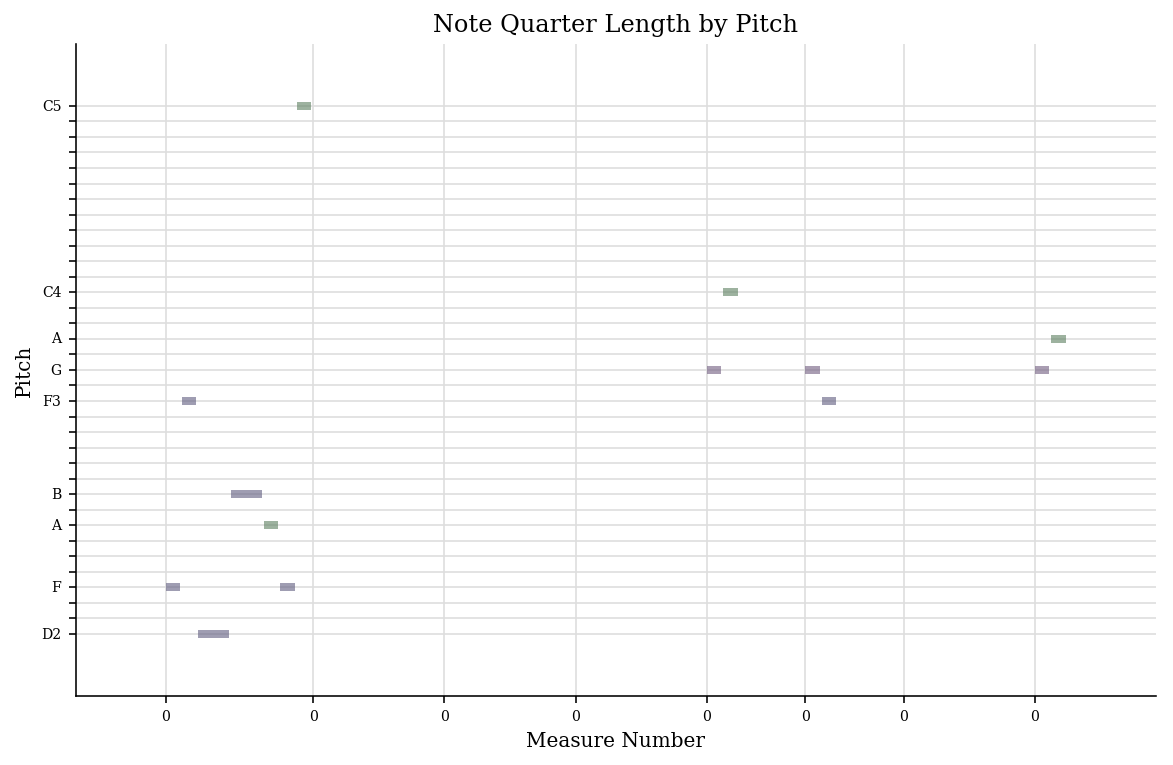

In [188]:
new_score.plot()

In [176]:
for m in new_score.getElementsByClass('Measure'):
    print(m.duration)

<music21.duration.Duration 4.0>
<music21.duration.Duration 4.0>
<music21.duration.Duration 4.0>
<music21.duration.Duration 4.0>
<music21.duration.Duration 4.0>
<music21.duration.Duration 4.0>
<music21.duration.Duration 4.0>
<music21.duration.Duration 4.0>
